# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 




## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os, glob
import math

## Read in an Image

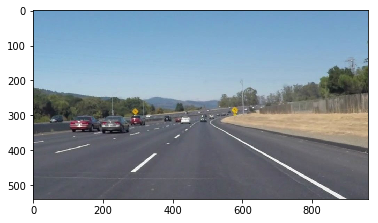

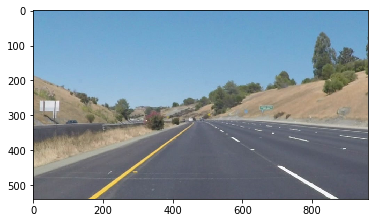

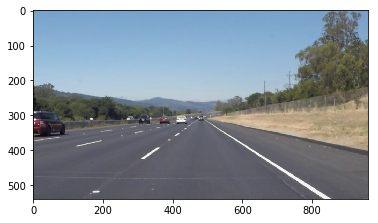

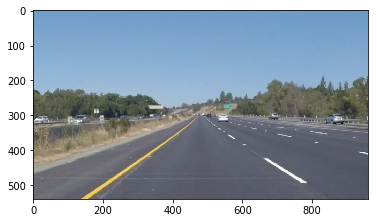

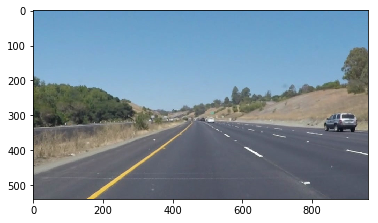

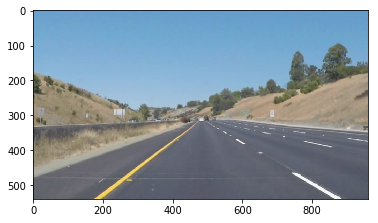

In [2]:
#reading in an image
images = os.listdir("test_images/")

test_images = []
for img in images:
    test_images.append(mpimg.imread("test_images/" + img))
    plt.figure()
    plt.imshow(mpimg.imread("test_images/" + img))

## Ideas for Lane Detection Pipeline

**Some OpenCV functions might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=11):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # initialize lists to hold line formula values
    bLeftValues     = []  # b of left lines
    bRightValues    = []  # b of Right lines
    mPositiveValues = []  # m of Left lines
    mNegitiveValues = []  # m of Right lines
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # calculate slope and intercept
            m = (y2-y1)/(x2-x1)
            b = y1 - x1*m
            
            # threshold to check for outliers
            if m >= 0 and (m < 0.2 or m > 0.8):
                continue
            elif m < 0 and (m < -0.8 or m > -0.2):
                continue
                
            # seperate positive line and negative line slopes
            if m > 0:
                mPositiveValues.append(m)
                bLeftValues.append(b)
            else:
                mNegitiveValues.append(m)
                bRightValues.append(b)
    
    # Get image shape and define y region of interest value
    imshape = img.shape
    y_max   = imshape[0] # lines initial point at bottom of image    
    y_min   = 330        # lines end point at top of ROI

    # Get the mean of all the lines values
    AvgPositiveM = mean(mPositiveValues)
    AvgNegitiveM = mean(mNegitiveValues)
    AvgLeftB     = mean(bLeftValues)
    AvgRightB    = mean(bRightValues)

    # use average slopes to generate line using ROI endpoints
    if AvgPositiveM != 0:
        x1_Left = (y_max - AvgLeftB)/AvgPositiveM
        y1_Left = y_max
        x2_Left = (y_min - AvgLeftB)/AvgPositiveM
        y2_Left = y_min
    if AvgNegitiveM != 0:
        x1_Right = (y_max - AvgRightB)/AvgNegitiveM
        y1_Right = y_max
        x2_Right = (y_min - AvgRightB)/AvgNegitiveM
        y2_Right = y_min

        # define average left and right lines
        cv2.line(img, (int(x1_Left), int(y1_Left)), (int(x2_Left), int(y2_Left)), color, thickness) #avg Left Line
        cv2.line(img, (int(x1_Right), int(y1_Right)), (int(x2_Right), int(y2_Right)), color, thickness) #avg Right Line

def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def color_filter(img,lower_limit,upper_limit):
    """
    color filtering
    Input img, lower_limit,upper_limit
    
    """
    return cv2.inRange(img, lower_limit, upper_limit)

def bit_combine(img_one,img_two):
    return cv2.bitwise_or(img_one,img_two) 

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# Building the pipeline that will draw lane lines  on the test_images
# And then I will save them to the test_images_output directory
import numpy as np
def process_image(image):

    #Creating gray scale image
    gray_image = grayscale(image)

    #Convert it as gaussian smoothing / blurring
    kernel_size = 5 #Kernel size is selected as 5.
    gaus_image = gaussian_blur(gray_image, kernel_size)

    #Geting Canny Image
    low_threshold = 50
    high_threshold = 150
    canny_image = canny(gaus_image, low_threshold, high_threshold)    

    #Creating region of interest
    imshape = image.shape
    poly = np.array([[(50,imshape[0]),(460, 310), (490, 310), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    reg_image = region_of_interest(canny_image, poly)

    #Hough tranformation
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 22     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 18 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    hough_line_image = hough_lines(reg_image, rho, theta, threshold, min_line_len, max_line_gap)

    #Draw lines on edge image
    imageWithLines = weighted_img(hough_line_image,image)
    return imageWithLines

## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
imglist = os.listdir("test_images/")
for img in imglist:
    image = mpimg.imread('test_images/' + img)
    lines = process_image(image)

Let's try the one with the solid white lane on the right first ...

True

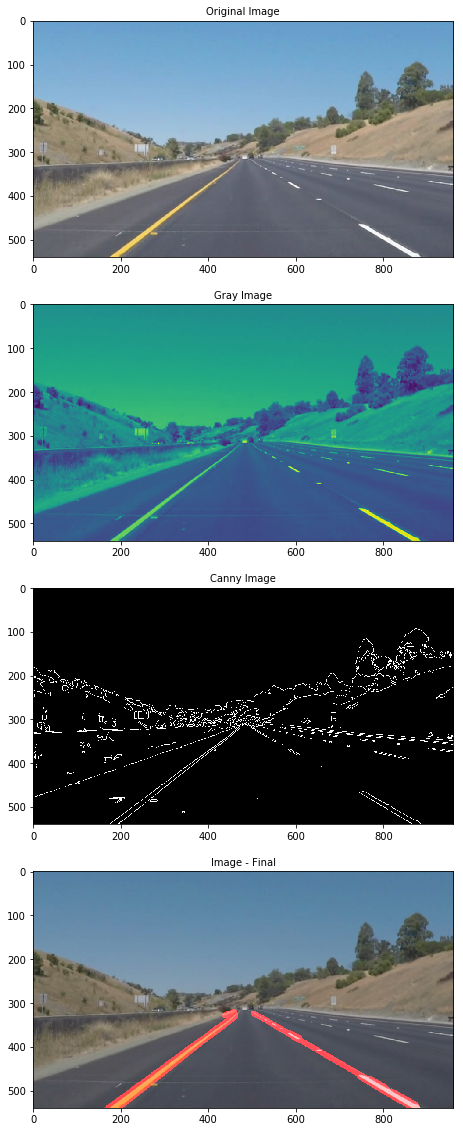

In [17]:
# Visualization of transformation
# Visualize transformation
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30,20))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)

gray_image = grayscale(image)
ax2.imshow(gray_image)
ax2.set_title('Gray Image', fontsize=10)

low_threshold = 50
high_threshold = 150
canny_image = canny(gray_image, low_threshold, high_threshold) 
ax3.imshow(canny_image, cmap = 'gray')
ax3.set_title('Canny Image', fontsize=10)

ax4.imshow(process_image(image))
ax4.set_title('Image - Final', fontsize=10)

cv2.imwrite('img/original.jpg',image)
cv2.imwrite('img/canny.jpg',canny_image)
cv2.imwrite('img/gray.jpg',gray_image)
cv2.imwrite('img/finaloutput.jpg',process_image(image))

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 16.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.47 s, sys: 158 ms, total: 2.63 s
Wall time: 14 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:42<00:00, 16.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.6 s, sys: 633 ms, total: 8.23 s
Wall time: 44 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))